## Analyzing data for population affected by covid and HPSAs in counties and states

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 320
pd.options.display.max_rows = 60

In [2]:
file_hpsa = '03_cleaned_hpsas_filtered.csv'
file_covid = '05_cleaned_covid_cumulative.csv'
file_path = '../datasets/'

In [3]:
hpsa = pd.read_csv(file_path + file_hpsa)
hpsa.head(3)

,HPSA Designation Date,HPSA Name,Designation Type,HPSA Score,HPSA Status,HPSA Designation Last Update Date,HPSA Degree of Shortage,Withdrawn Date,HPSA FTE,HPSA Designation Population,% of Population Below 100% Poverty,HPSA Formal Ratio,Primary HHS Region Name,Rural Status,Longitude,Latitude,Common County Name,Common State County FIPS Code,County Equivalent Name,HPSA Component Type Description,HPSA Designation Population Type Description,HPSA Estimated Served Population,HPSA Estimated Underserved Population,HPSA Provider Ratio Goal,HPSA Shortage,State Name,U.S. - Mexico Border 100 Kilometer Indicator,U.S. - Mexico Border County Indicator,Designation,State Population
0,1978-01-23,Warren,Geographic HPSA,0,Withdrawn,1995-10-02,Not applicable,1995-10-02,1.0,83300.0,5.4,0,Region 2,NaN,NaN,NaN,"Warren County, NJ",34041,Warren,Single County,Geographic Population,0.0,0.0,NaN,NaN,New Jersey,N,N,Geographic,8882190.0
1,1978-04-07,Halifax Mental Health Catchment Area,Geographic HPSA,0,Withdrawn,2011-11-03,Not applicable,2011-11-03,3.0,0.0,NaN,0,Region 4,Rural,NaN,NaN,"Halifax County, NC",37083,Halifax,Single County,Geographic Population,0.0,0.0,NaN,0.0,North Carolina,N,N,Geographic,10488084.0
2,1978-04-24,Metropolitan State Hospital,State Mental Hospital,0,Withdrawn,1986-08-19,Not applicable,1986-08-19,22.0,0.0,NaN,0,Region 9,Partially Rural,-119.27023,36.374106,"Tulare County, CA",06107,Tulare,Unknown,State Mental Hospital,0.0,0.0,300:1,0.0,California,U,N,Facility,39512223.0


In [4]:
hpsa['HPSA Designation Date'] = pd.to_datetime(hpsa['HPSA Designation Date'])
hpsa.set_index('HPSA Designation Date', inplace = True)
hpsa.sort_index(inplace = True)
hpsa = hpsa['2019':]
hpsa.reset_index(inplace = True)

In [5]:
covid = pd.read_csv(file_path + file_covid)
covid.head(3)

,Unnamed: 0,date,covid cases,countyFIPS,County Name,State,stateFIPS
0,0,1/22/20,0,0,Statewide Unallocated,AL,1
1,1,1/23/20,0,0,Statewide Unallocated,AL,1
2,2,1/24/20,0,0,Statewide Unallocated,AL,1


Create a dataframe for one state

In [11]:
# The following function will create a dataframe for a given state and the cumulative covid data
def covid_by_state(state_abbr):
    df_state = covid[covid['State'] == state_abbr][['date', 'covid cases']].copy()
    df_state['date'] = pd.to_datetime(df_state['date'])
    df_state.set_index('date', inplace = True)
    df_state = df_state.resample('D').sum()
    
    total_covid = df_state.tail(1).values[0]

    print(f'DataFrame for cumulative confirmed Covid cases created for {state_abbr}.')
    print(f'There are a total of {total_covid[0]} confirmed cases in {state_abbr} as of 12/1/2020.')
    
    return df_state

In [12]:
# The following function summarizes the information for unique HPSAs for a given state
def unique_hpsas_by_state(state_name, covid_state_df):
    
    # Total entries for the state from 2019-2020
    entries = hpsa[hpsa['State Name'] == state_name].shape[0]
    print(f'Total number of HPSAs for {state_name}: {entries}')
    
    
    hpsa_state = hpsa[hpsa['State Name'] == state_name].copy()
      
    hpsa_state['cumulative_covid_cases'] = hpsa_state['HPSA Designation Date'].map(lambda date: 
                                                                    covid_state_df[date:date]['covid cases'].values)
    hpsa_state['cumulative_covid_cases'] = hpsa_state['cumulative_covid_cases'].map(lambda arr:
                                                                                    arr[0] if len(arr)>0 else 0)
    return hpsa_state

In [13]:
# Time series graph for percentage of underserved population and percentage of people who have had covid
def underserved_vs_covid_state(state_name, hpsa_state, state_pop):
   
    hpsa_state['HPSA Designation Date'] = pd.to_datetime(hpsa_state['HPSA Designation Date'])
    hpsa_state.set_index('HPSA Designation Date', inplace = True)
    
    temp_df = hpsa_state.copy()
    temp_df['Underserved Population'] = temp_df[['HPSA Estimated Underserved Population']].cumsum()
    temp_df['% underserved population'] = temp_df['Underserved Population'].map(lambda cell: (cell/state_pop)*100)
    temp_df['% covid cases'] = temp_df['cumulative_covid_cases'].map(lambda cell: (cell/state_pop)*100)
    
    plt.figure(figsize=(10, 5))
    plt.plot(temp_df['% covid cases'], label = '% covid cases')
    plt.plot(temp_df['% underserved population'], label='% underserved population')
    plt.title(f'Percent of Total Population - {state_name}')
    plt.legend();

### Which states and counties will require more mental health workers as a result of covid-19?

DataFrame for cumulative confirmed Covid cases created for FL.
There are a total of 1008166 confirmed cases in FL as of 12/1/2020.
Total number of HPSAs for Florida: 83


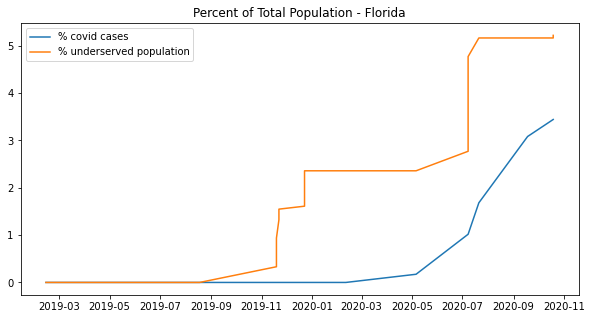

In [16]:
# Florida
covid_FL = covid_by_state('FL')
hpsa_FL = unique_hpsas_by_state('Florida', covid_FL)
underserved_vs_covid_state('Florida', hpsa_FL, 21_993_000)

DataFrame for cumulative confirmed Covid cases created for CA.
There are a total of 1245662 confirmed cases in CA as of 12/1/2020.
Total number of HPSAs for California: 161


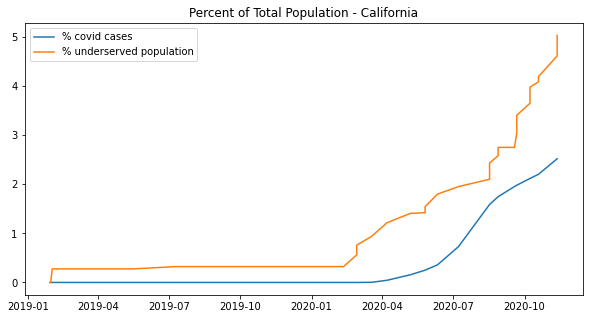

In [19]:
# California
covid_CA = covid_by_state('CA')
hpsa_CA = unique_hpsas_by_state('California', covid_CA)
underserved_vs_covid_state('California', hpsa_CA, 39_937_500)

DataFrame for cumulative confirmed Covid cases created for MI.
There are a total of 395453 confirmed cases in MI as of 12/1/2020.
Total number of HPSAs for Michigan: 69


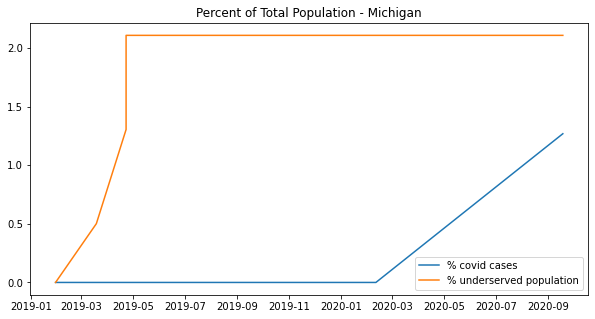

In [21]:
covid_MI = covid_by_state('MI')
hpsa_MI = unique_hpsas_by_state('Michigan', covid_MI)
underserved_vs_covid_state('Michigan', hpsa_MI, 10_045_000)

DataFrame for cumulative confirmed Covid cases created for TX.
There are a total of 1198366 confirmed cases in TX as of 12/1/2020.
Total number of HPSAs for Texas: 145


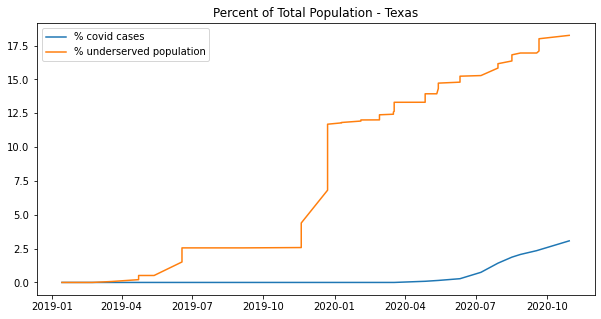

In [23]:
covid_TX = covid_by_state('TX')
hpsa_TX = unique_hpsas_by_state('Texas', covid_TX)
underserved_vs_covid_state('Texas', hpsa_TX, 29_472_300)

## Analysis by County

In [24]:
# Function to get the number of cumulative confirmed covid cases per county
def covid_by_county(county_name, state_abbr):
    
    df_county=covid[(covid['County Name']==county_name)&(covid['State']==state_abbr)][['date','covid cases']].copy()
    df_county['date'] = pd.to_datetime(df_county['date'])
    df_county.set_index('date', inplace = True)
    
    total_covid = df_county['covid cases'].tail(1).values[0]

    print(f'DataFrame for Cumulative Confirmed Covid Cases created for {county_name}.') 
    print(f'There are a total of {total_covid} confirmed cases as of 12/1/2020 for this county')
    
    return df_county

In [25]:
# Function to summarize the information for unique HPSAs for a county
def unique_hpsas_by_county(county_name, covid_county_df):
    
    # Total entries for the county from 2019-2020
    entries = hpsa[hpsa['Common County Name'] == county_name].shape[0]
    print(f'Total number of HPSA entries for {county_name} for 2020: {entries}')
    
    hpsa_county = hpsa[hpsa['Common County Name'] == county_name].copy()
        
    hpsa_county['cumulative_covid_cases'] = hpsa_county['HPSA Designation Date'].map(lambda date: 
                                                                    covid_county_df[date:date]['covid cases'].values)
    hpsa_county['cumulative_covid_cases'] = hpsa_county['cumulative_covid_cases'].map(lambda arr:
                                                                                    arr[0] if len(arr)>0 else 0)
    return hpsa_county

In [26]:
# Time series graph for percentage of underserved population and percentage of people who have had covid
def underserved_vs_covid(county_name, hpsa_county, county_pop):
   
    hpsa_county['HPSA Designation Date'] = pd.to_datetime(hpsa_county['HPSA Designation Date'])
    hpsa_county.set_index('HPSA Designation Date', inplace = True)
    
    temp_df = hpsa_county.copy()
    temp_df['Underserved Population'] = temp_df[['HPSA Estimated Underserved Population']].cumsum()
    temp_df['% underserved population'] = temp_df['Underserved Population'].map(lambda cell: (cell/county_pop)*100)
    temp_df['% covid cases'] = temp_df['cumulative_covid_cases'].map(lambda cell: (cell/county_pop)*100)
    
    plt.figure(figsize=(10, 5))
    plt.plot(temp_df['% covid cases'], label = '% covid cases')
    plt.plot(temp_df['% underserved population'], label='% underserved population')
    plt.title(f'Percent of Total Population for {county_name}')
    plt.legend();

DataFrame for Cumulative Confirmed Covid Cases created for Los Angeles County.
There are a total of 408396 confirmed cases as of 12/1/2020 for this county
Total number of HPSA entries for Los Angeles County, CA for 2020: 27


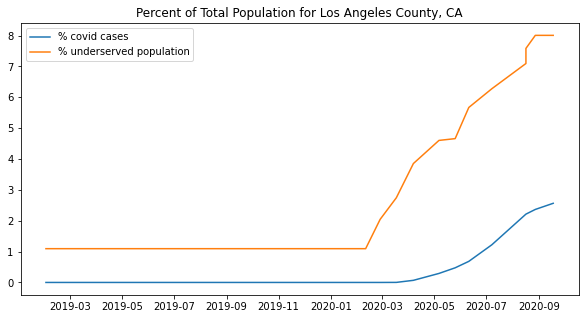

In [28]:
# Analysis for HPSAs in Los Angeles County, CA
covid_LOS_ANGELES = covid_by_county('Los Angeles County', 'CA')
hpsa_LOS_ANGELES = unique_hpsas_by_county('Los Angeles County, CA', covid_LOS_ANGELES)
underserved_vs_covid('Los Angeles County, CA', hpsa_LOS_ANGELES, 10_079_000)

DataFrame for Cumulative Confirmed Covid Cases created for Dallas County.
There are a total of 126690 confirmed cases as of 12/1/2020 for this county
Total number of HPSA entries for Dallas County, TX for 2020: 9


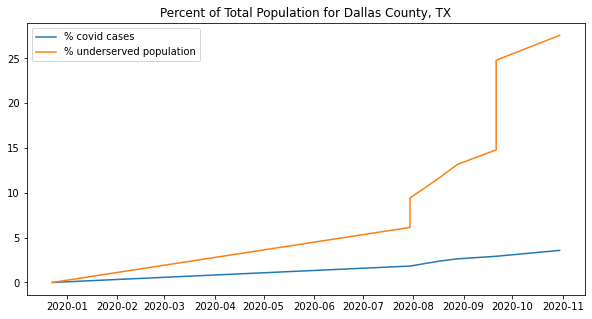

In [29]:
# Analysis for HPSAs in Dallas County, TX
covid_DALLAS = covid_by_county('Dallas County', 'TX')
hpsa_DALLAS = unique_hpsas_by_county('Dallas County, TX', covid_DALLAS)
underserved_vs_covid('Dallas County, TX', hpsa_DALLAS, 2_667_720)

DataFrame for Cumulative Confirmed Covid Cases created for San Diego County.
There are a total of 83421 confirmed cases as of 12/1/2020 for this county
Total number of HPSA entries for San Diego County, CA for 2020: 10


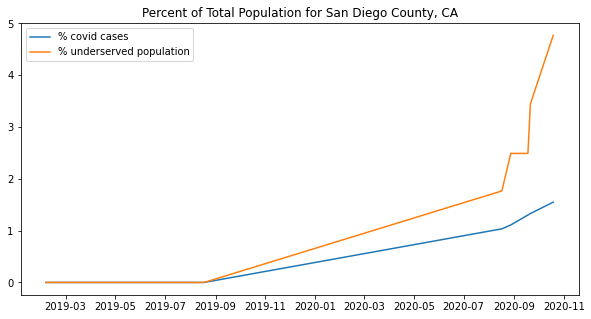

In [30]:
# San Diego County, CA 
covid_SAN_DIEGO = covid_by_county('San Diego County', 'CA')
hpsa_SAN_DIEGO = unique_hpsas_by_county('San Diego County, CA', covid_SAN_DIEGO)
underserved_vs_covid('San Diego County, CA', hpsa_SAN_DIEGO, 3_379_160)